# ANA 540 Final Examination - Classification using SVM

In [101]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import sys
import os

import sklearn
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from packaging import version

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "SVM"

In [102]:
import urllib.request
from pathlib import Path

IMAGES_PATH = Path() / "images" / "SVM"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [103]:
descriptors_url = 'https://raw.githubusercontent.com/LukeWoodSMU/Mushroom-Classification/master/raw_data/descriptors.txt'
descriptors = requests.get(descriptors_url).text

def get_attribute_dictionary():
    # Loads from the descriptors file all attributes w/ mapping to their mappings
    attr_dict = dict([(x.split(":")[0],dict([[y.split("=")[1].strip(),y.split("=")[0].strip()] for y in x.split(":")[1].split(",")])) for x in descriptors.splitlines()])
    attr_dict.pop('stalk-root', None)
    return attr_dict
    

def get_data_frame(remove_dups=False):
    attribute_names = [x.split(":")[0] for x in descriptors.splitlines()]
    df = pd.read_csv('https://raw.githubusercontent.com/LukeWoodSMU/Mushroom-Classification/master/raw_data/agaricus-lepiota.data.txt',names=attribute_names)

    for col in df.columns:
        df[col] = df[col].astype('category')

    if(remove_dups):
        df = df.drop_duplicates()
    
    df.drop('stalk-root', inplace=True, axis=1)
    
    return df

In [104]:
df = get_data_frame()
total_rows = len(df)

df.drop_duplicates(inplace=True)
no_dups = len(df)

print ("Total duplicates: ", (total_rows - no_dups))

Total duplicates:  0


In [105]:
df

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [106]:
df.rename(columns = {'poisonous':'class'}, inplace=True)

In [107]:
#What data is there? 
df.dtypes

class                       category
cap-shape                   category
cap-surface                 category
cap-color                   category
bruises                     category
odor                        category
gill-attachment             category
gill-spacing                category
gill-size                   category
gill-color                  category
stalk-shape                 category
stalk-surface-above-ring    category
stalk-surface-below-ring    category
stalk-color-above-ring      category
stalk-color-below-ring      category
veil-type                   category
veil-color                  category
ring-number                 category
ring-type                   category
spore-print-color           category
population                  category
habitat                     category
dtype: object

In [108]:
#Are there any missing values?
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [109]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


# Linear SVM Classification

In [110]:
# Using LabelEncoder to convert catergory values to ordinal
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])

df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [111]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,...,8124.000000,8124.000000,8124.000000,8124.0,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,0.482029,3.348104,1.827671,4.504677,0.415559,4.144756,0.974151,0.161497,0.309207,4.810684,...,1.603644,5.816347,5.794682,0.0,1.965534,1.069424,2.291974,3.596750,3.644018,1.508616
std,0.499708,1.604329,1.229873,2.545821,0.492848,2.103729,0.158695,0.368011,0.462195,3.540359,...,0.675974,1.901747,1.907291,0.0,0.242669,0.271064,1.801672,2.382663,1.252082,1.719975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,3.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2.000000,...,1.000000,6.000000,6.000000,0.0,2.000000,1.000000,0.000000,2.000000,3.000000,0.000000
50%,0.000000,3.000000,2.000000,4.000000,0.000000,5.000000,1.000000,0.000000,0.000000,5.000000,...,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,2.000000,3.000000,4.000000,1.000000
75%,1.000000,5.000000,3.000000,8.000000,1.000000,5.000000,1.000000,0.000000,1.000000,7.000000,...,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,4.000000,7.000000,4.000000,2.000000
max,1.000000,5.000000,3.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,11.000000,...,3.000000,8.000000,8.000000,0.0,3.000000,2.000000,4.000000,8.000000,5.000000,6.000000


### Set up the training and test sets

In [112]:
from sklearn.model_selection import train_test_split
y = df["class"]
# All data except "class" column.
X = df.drop(["class"], axis=1)
# Split data for train and test.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, shuffle=True, test_size=0.2)

In [113]:
df['class'].value_counts(sort=False)

1    3916
0    4208
Name: class, dtype: int64

In [114]:
y_train.head()

7873    1
6515    1
6141    1
2764    0
438     0
Name: class, dtype: int32

### Apply SVM using a linear kernel

In [119]:
from sklearn import svm

clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

predictions_svm = clf.predict(X_test)

acc_svm = accuracy_score(predictions_svm, y_test)
print('Accuracy of SVM Model: %', 100 * acc_svm)

Accuracy of SVM Model: % 95.75384615384615


In [120]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = clf.predict(X_test)

#I have checked the order of tn, fp, fn, and tp w.r.t. the confusion matrix() command and the 
#following is the correct order
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n")
print("Confusion Maxtrix")
print(confusion_matrix(y_test, y_pred))
print()
print()

print(f'\nTrue Positives: {tp}')
print(f'\nFalse Positives: {fp}')
print(f'\nTrue Negatives: {tn}')
print(f'\nFalse Negatives: {fn}')

print()
print()
print(f'True Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

tpr = (tp / (tp + fn))
fpr = (tn / (tn + fp))



Confusion Maxtrix
[[804  39]
 [ 30 752]]



True Positives: 752

False Positives: 39

True Negatives: 804

False Negatives: 30


True Positive Rate: 0.9616368286445013
Specificity: 0.9537366548042705
False Positive Rate: 0.046263345195729534


In [121]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       843
           1       0.95      0.96      0.96       782

    accuracy                           0.96      1625
   macro avg       0.96      0.96      0.96      1625
weighted avg       0.96      0.96      0.96      1625



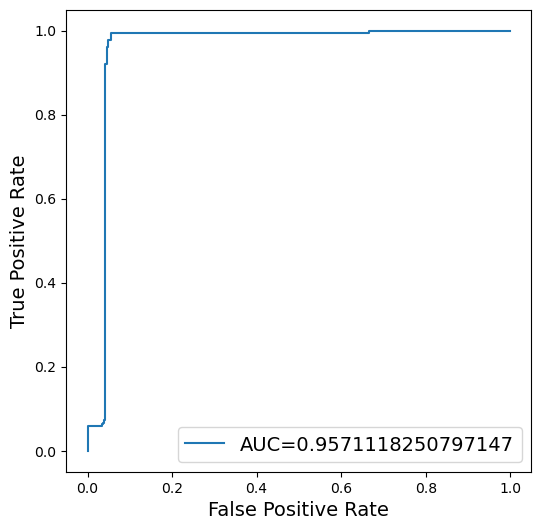

In [123]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt_1 = plt.figure(figsize=(6,6))

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()